# 시계열 데이터 사례 분석

## 사계열 생성

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath = './data/daily-min-temperatures.csv'
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [14]:
# series 형태로 저장
ts1 = df['Temp']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

## 시계열의 정상성(Stationarity) 정성적 분석

In [7]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 

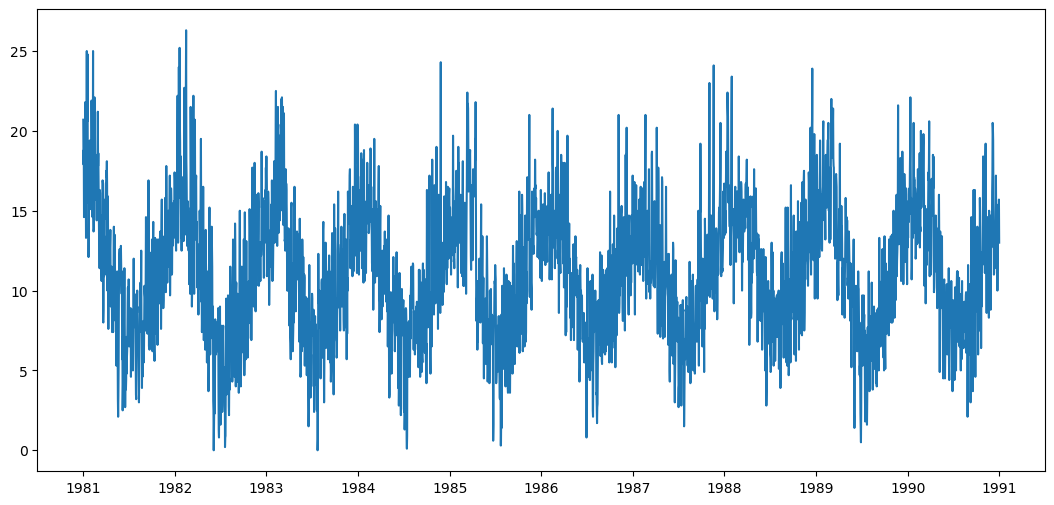

In [9]:
plt.plot(ts1)
plt.show()

In [11]:
# 결측치 확인
ts1.isna().sum()

np.int64(0)

Series([], Name: Temp, dtype: float64)


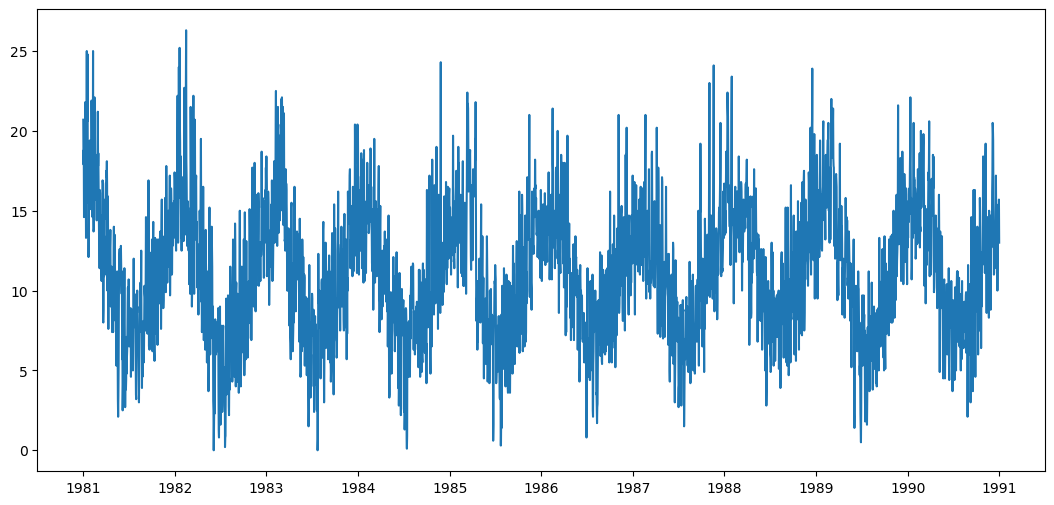

In [15]:
ts1=ts1.interpolate(method='time')
print(ts1[ts1.isna()])
plt.plot(ts1)

In [21]:
ts1.rolling(window=12).mean()[:13]

Date
1981-01-01          NaN
1981-01-02          NaN
1981-01-03          NaN
1981-01-04          NaN
1981-01-05          NaN
1981-01-06          NaN
1981-01-07          NaN
1981-01-08          NaN
1981-01-09          NaN
1981-01-10          NaN
1981-01-11          NaN
1981-01-12    17.341667
1981-01-13    17.008333
Name: Temp, dtype: float64

In [24]:
# 이동평균, 이동표준편차 시각화 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='b',label='Original')    
    mean = plt.plot(rolmean, color='r', label='Rolling Mean')
    std = plt.plot(rolstd, color='k', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

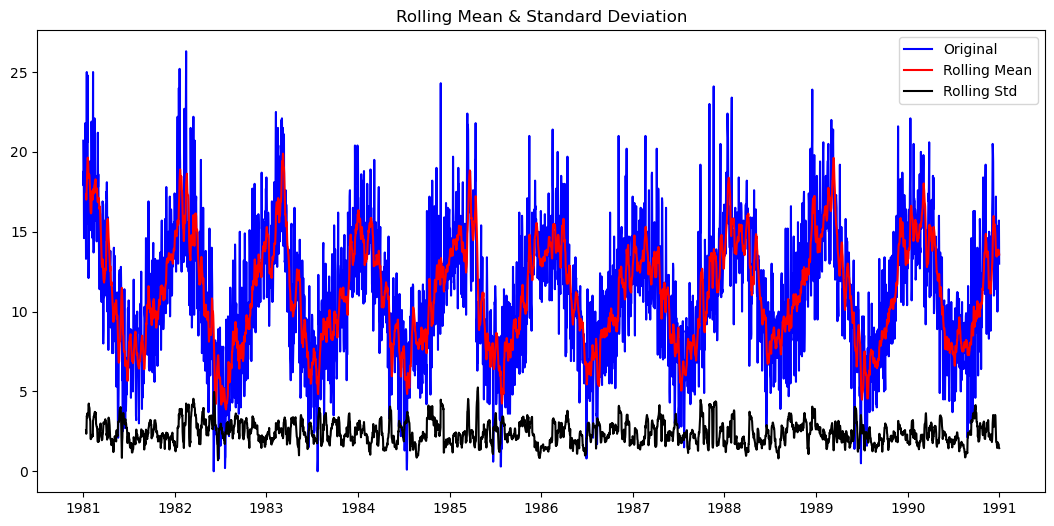

In [27]:
plot_rolling_statistics(ts1, window=12) 

In [26]:
ts1.rolling(window=12).mean()[:12] # 최근 12개(12일, Date가 일 단위이기 때문) 샘플 단위로 rolling mean 계산

Date
1981-01-01          NaN
1981-01-02          NaN
1981-01-03          NaN
1981-01-04          NaN
1981-01-05          NaN
1981-01-06          NaN
1981-01-07          NaN
1981-01-08          NaN
1981-01-09          NaN
1981-01-10          NaN
1981-01-11          NaN
1981-01-12    17.341667
Name: Temp, dtype: float64

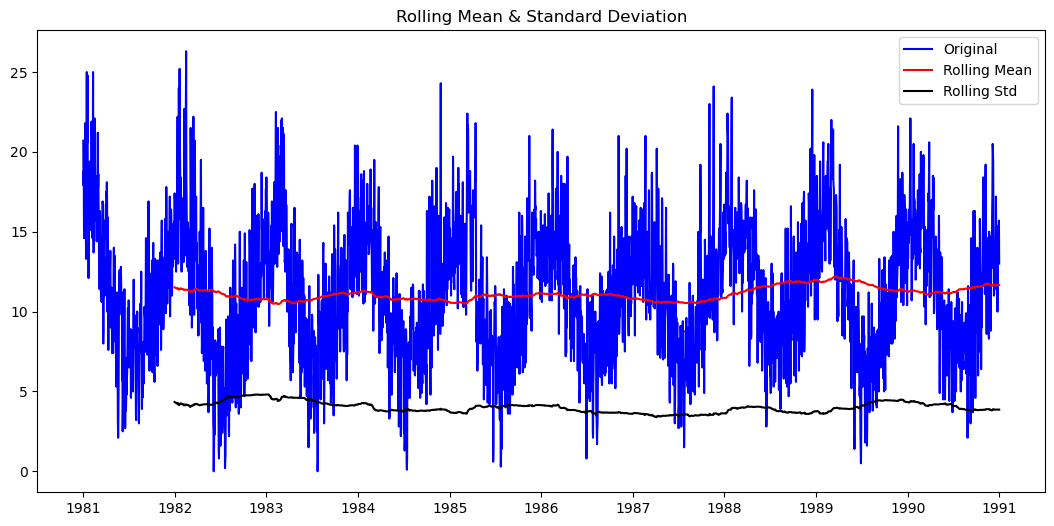

In [29]:
plot_rolling_statistics(ts1, window=365) # 1년 단위로

# 다른 시계열 데이터와 비교

In [30]:
dataset_filepath = './data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


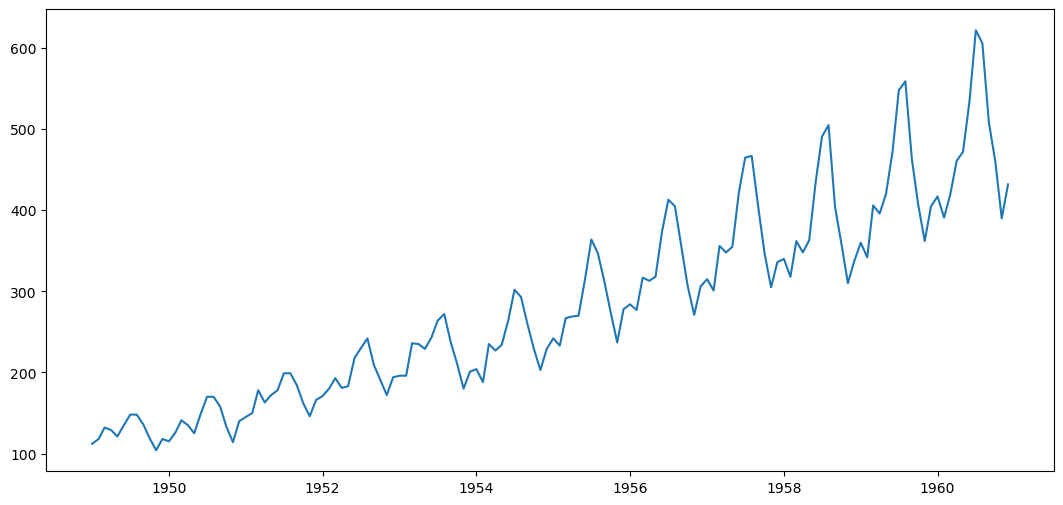

In [31]:
ts2 = df['Passengers']
plt.plot(ts2)
plt.show()

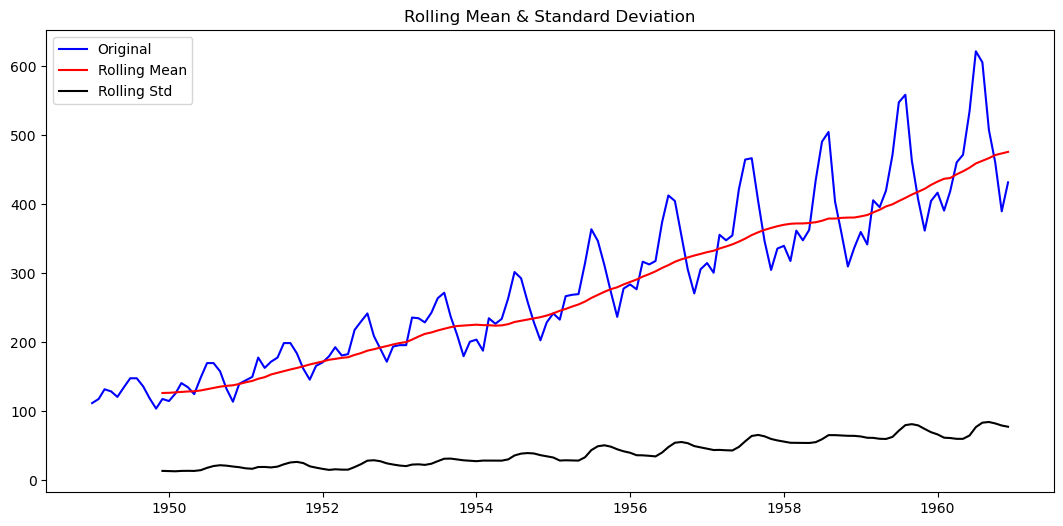

In [32]:
plot_rolling_statistics(ts2, window=12)

# 정상성 체크하는 통계적 기법

## Augmented Dickey-Fulller Test (ADF test)

- H0: 주어진 시계열 데이터가 안정적이지 않다.
- H1: 주어진 시계열 데이터는 안정적이다.

In [34]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  # AIC 기준으로 lag 자동 설정
    
    # 리턴 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [38]:
# Daily-min-temp 데이터
augmented_dickey_fuller_test(ts1) 

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


- ts1은 stationary time-series이다. (귀무가설 기각 대립가설 채틱)

In [39]:
# airline-passengers 데이터
augmented_dickey_fuller_test(ts2) 

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


- ts2는 stationary 하지 않다. (귀무가설 기각 실패)

## 보다 stationary한 시계열로 가공하기

### 1. 로그함수 변환 - 분산을 일정하게

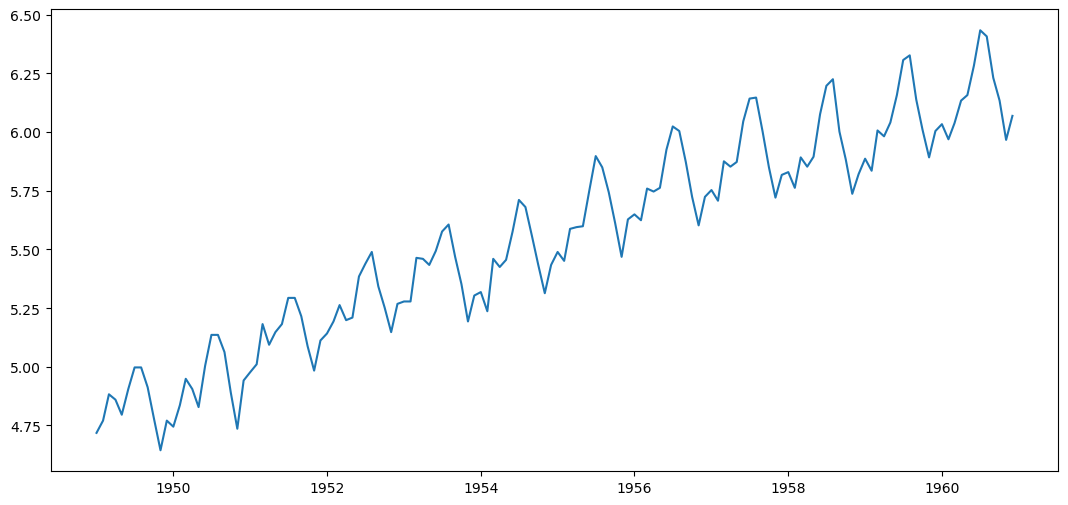

In [43]:
ts_log = np.log(ts2)
plt.plot(ts_log)
plt.show()

In [44]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### 2. Moving average 제거 - 추세(Trend) 상쇄하기

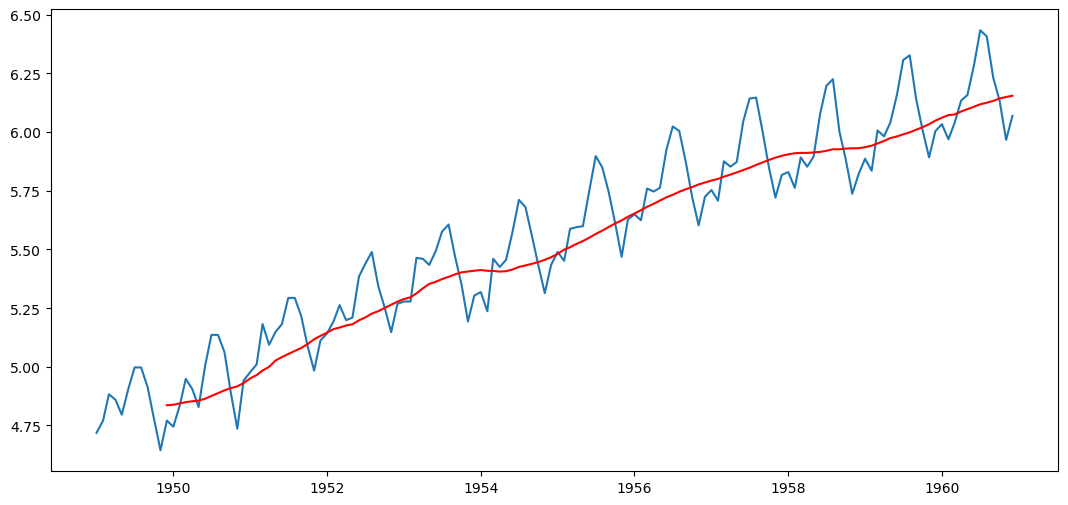

In [45]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [46]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [47]:
# Rolling 후의 Null값 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

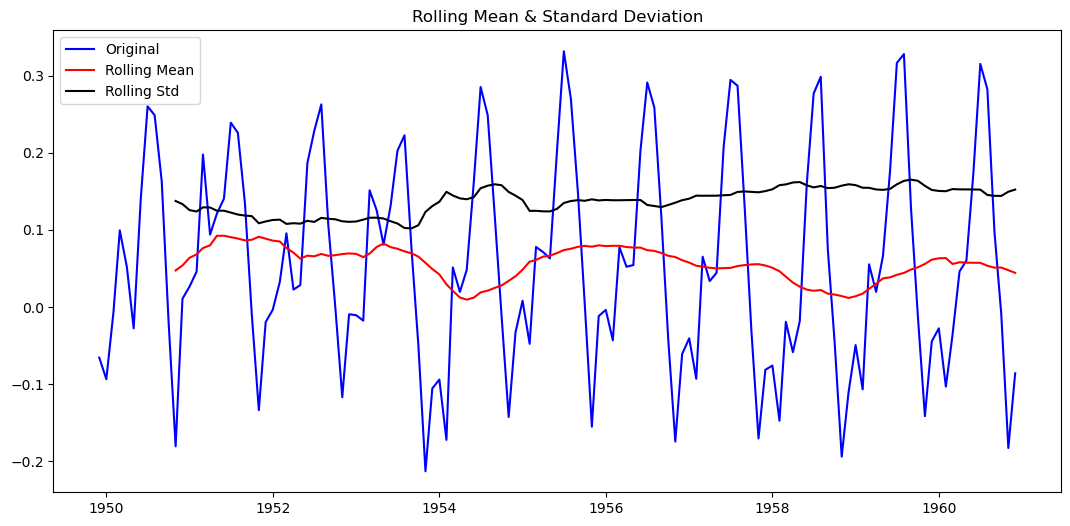

In [64]:
plot_rolling_statistics(ts_log_moving_avg)

- Step1: Log 변환을 통해 분산을 일정하게
- Step2: log변환된 값들에서 이동평균을 제거(변화량 제거)
- Step3: rolling으로 생성된 null값 삭제

In [52]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


- 이제 이 시계열은 95% 이상의 confidence로 정상이다.

In [53]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

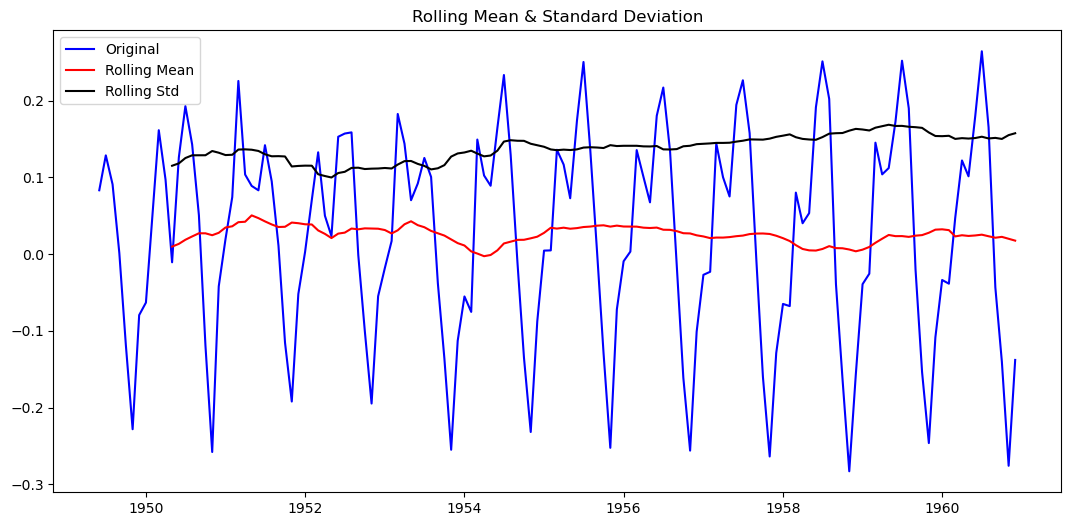

In [61]:
plot_rolling_statistics(ts_log_moving_avg_6, window=12)

In [65]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


### 3. 차분(Differencing) - 계절성(Seasonality) 상쇄하기
- 차분: 한 스텝에서 발생한 변화량 계산

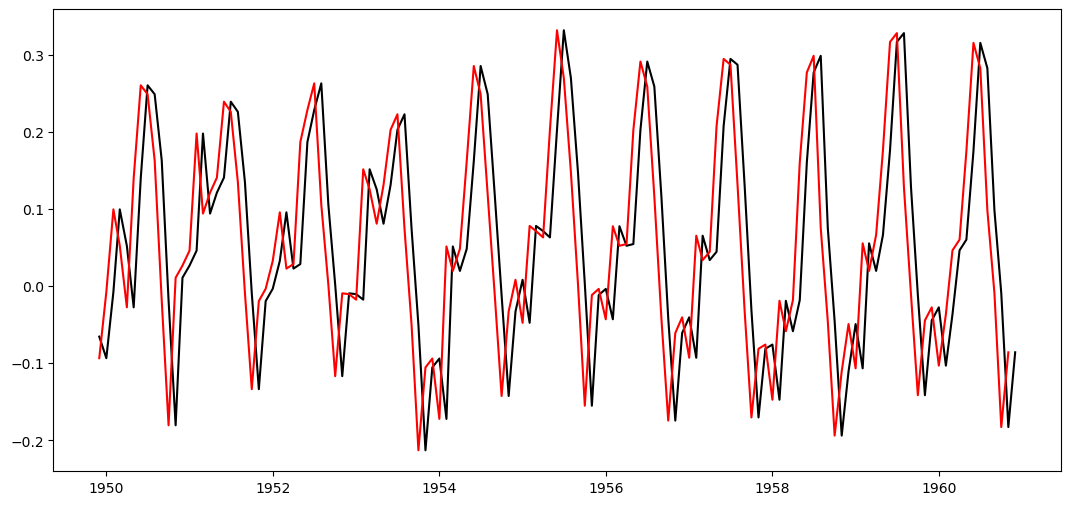

In [86]:
# row기준으로 한칸씩 이전값으로 으로 시프트
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)

# 시프트 전 후 값 plotting
plt.plot(ts_log_moving_avg, color='k')
plt.plot(ts_log_moving_avg_shift, color='r')
plt.show()

In [87]:
type(ts_log_moving_avg)

pandas.core.series.Series

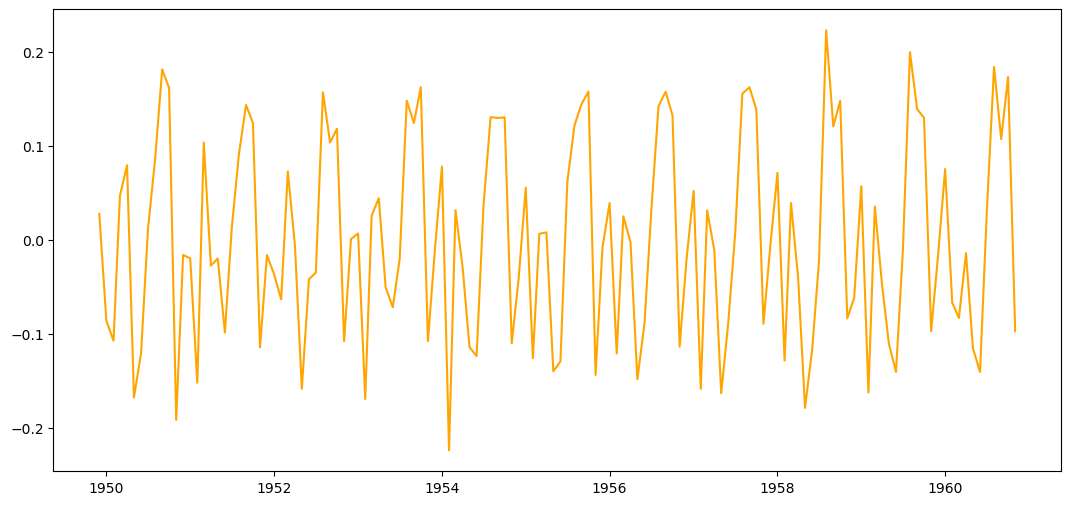

In [88]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 plotting
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff, color='orange')
plt.show()

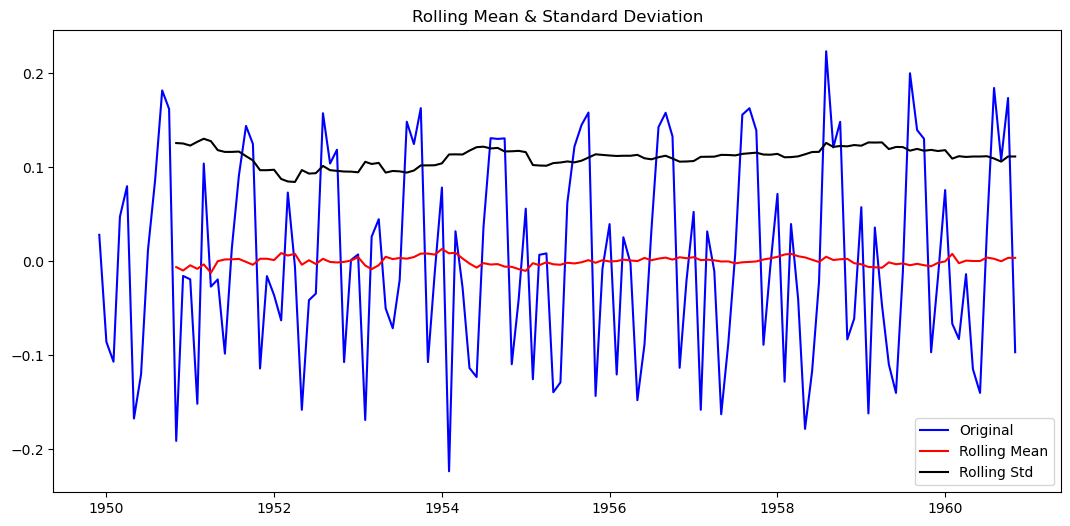

In [89]:
# 이동평균, 이동표준편차 시각화 - 정상성 여부 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

In [82]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


- 이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용
- Seasonality 효과를 다소 상쇄
- p-value가 약 0.022 에서 0.0019로 1/10 정도로 감소

## 시계열 분해(Time series decomposition)
- statsmodels 라이브러리의 seasonal_decompose()

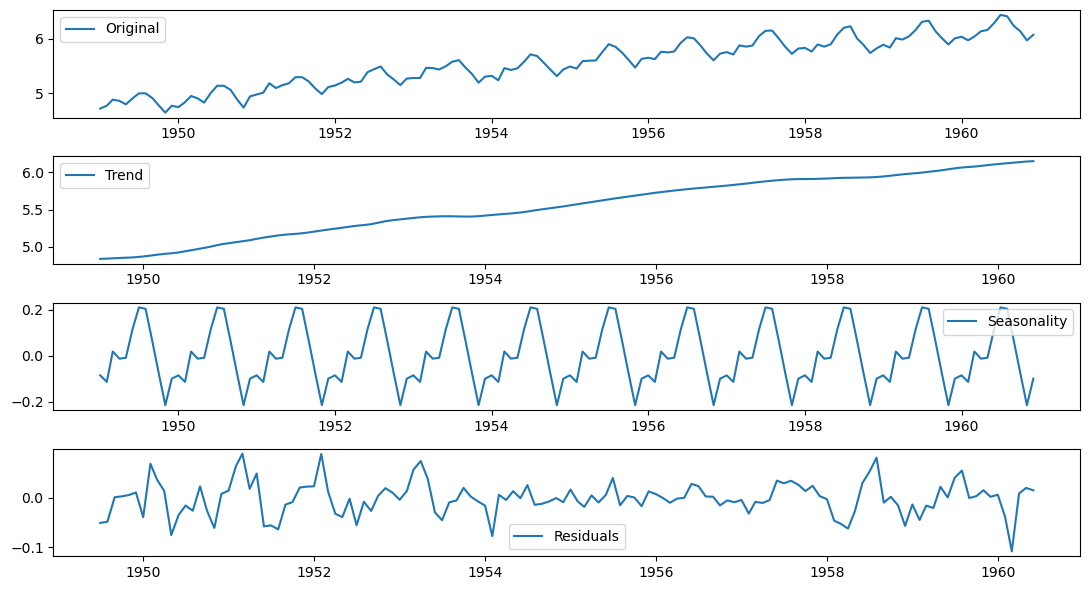

In [90]:
from statsmodels.tsa.seasonal import seasonal_decompose
# ts_log를 decomposition
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

 - Trend+Seasonality+Residual=Original

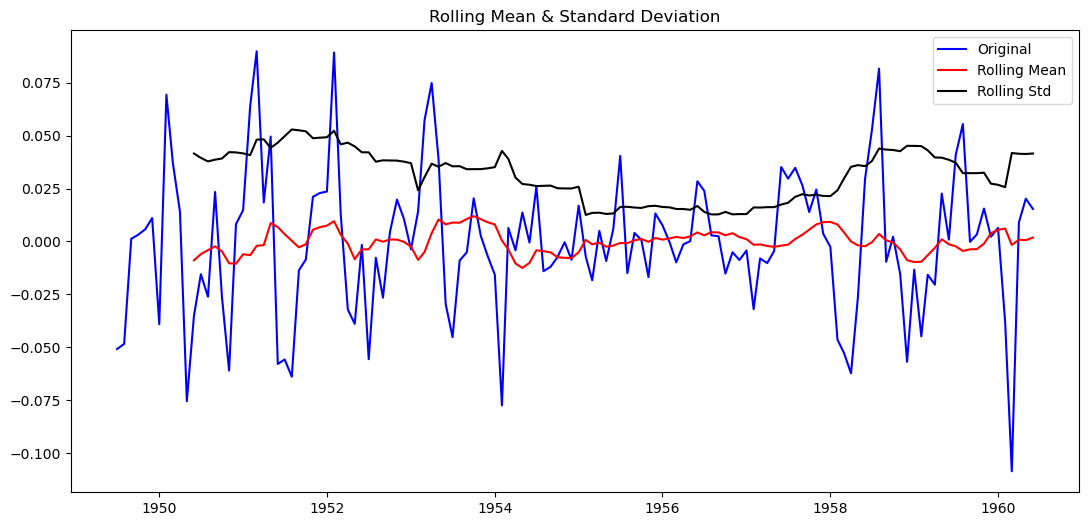

In [91]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [92]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


# ARIMA - ACF, PACF를 통해 모수를 설정해보자

## p 와 q

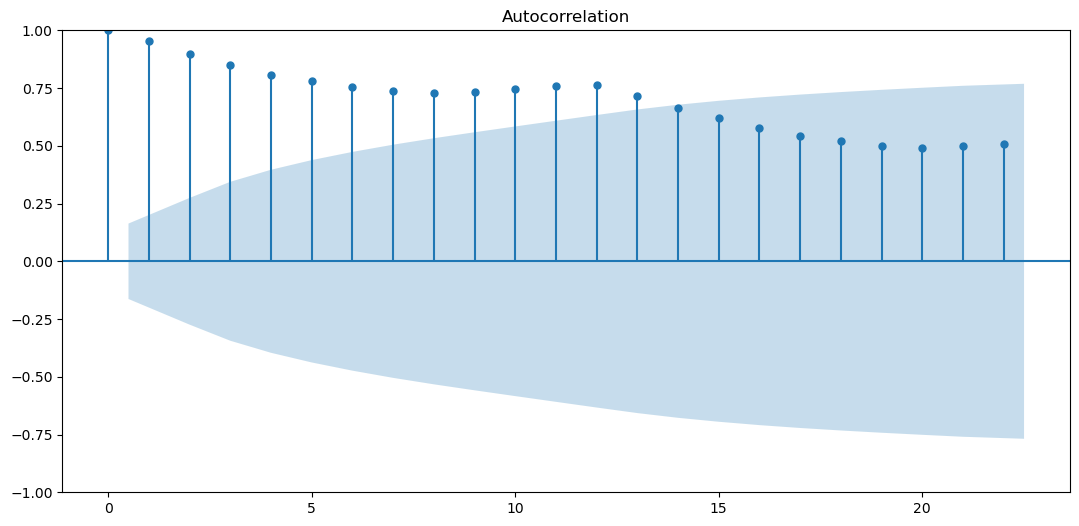

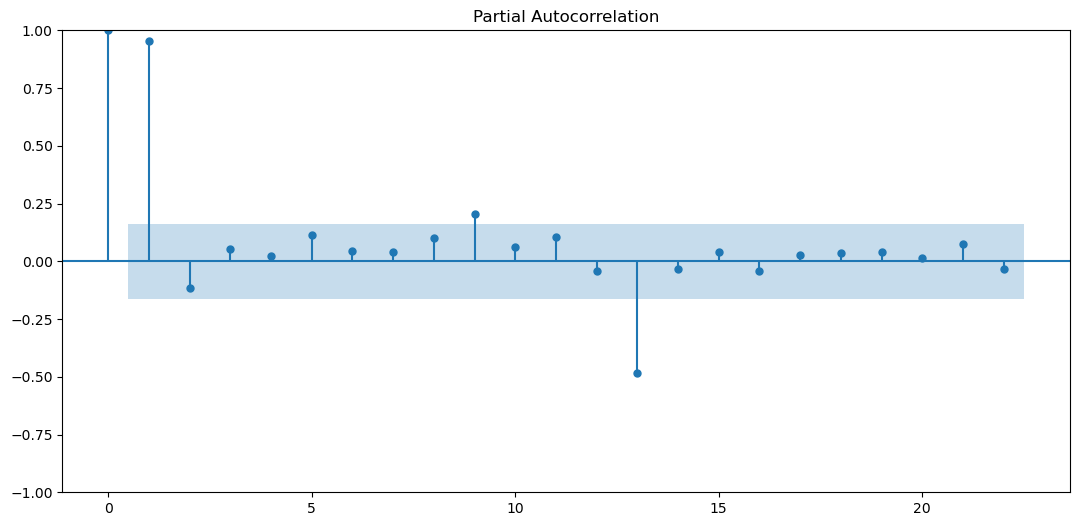

In [93]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## d

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


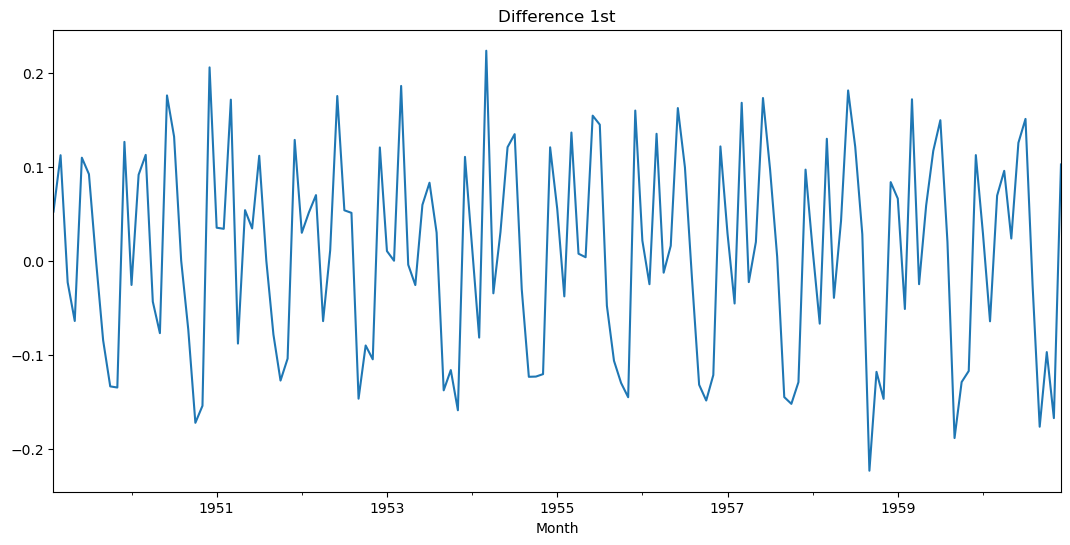

In [94]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


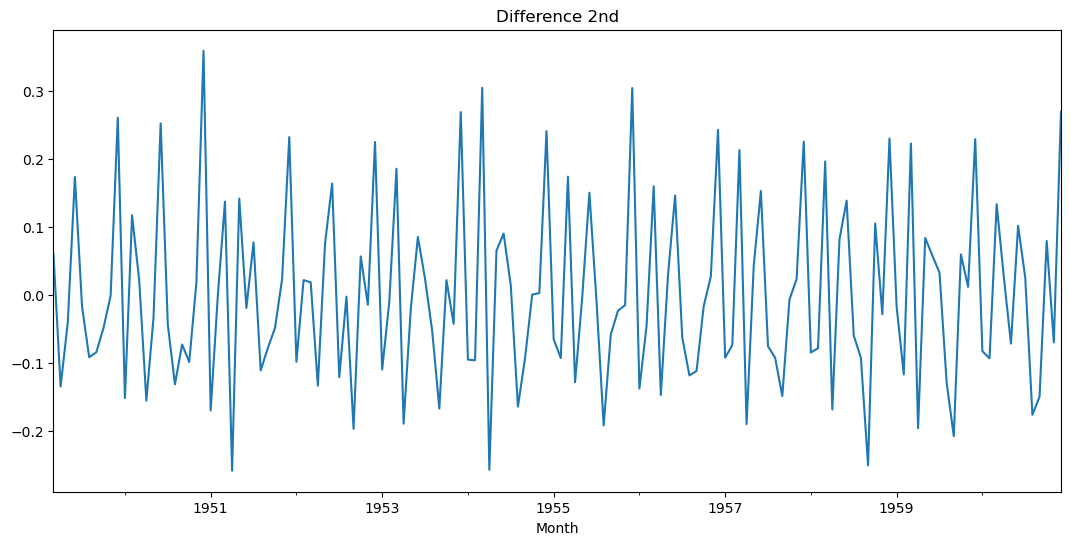

In [95]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 학습 데이터 분리

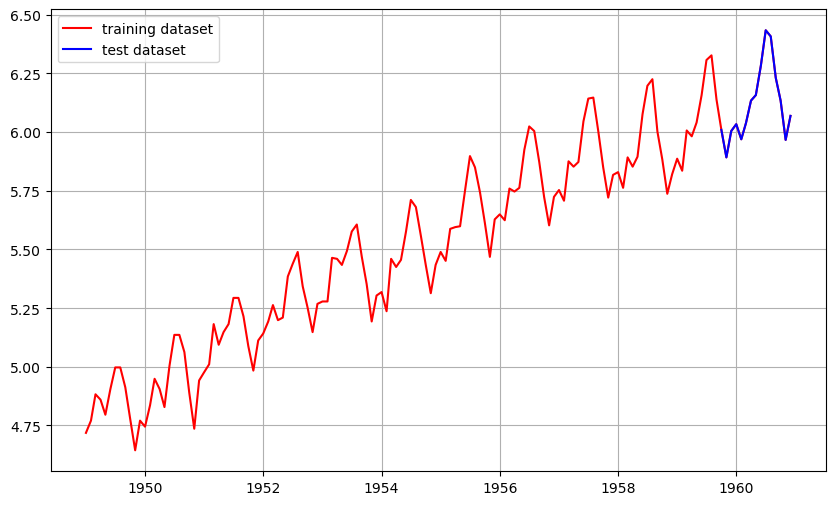

In [127]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

In [98]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


# ARIMA 모델 훈련과 추론

In [121]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# 모델 훈련
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

# 훈련 모델 요약
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.950
Date:                Fri, 12 Sep 2025   AIC                           -409.901
Time:                        17:06:38   BIC                           -367.120
Sample:                    01-01-1949   HQIC                          -392.519
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2795      0.081     -3.442      0.001      -0.439      -0.120
ar.L2         -0.0150      0.109     -0.138      0.890      -0.228       0.198
ar.L3          0.0005      0.046      0.012      0.9

In [124]:
# 모델 훈련
model = ARIMA(train_data, order=(13, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

# 훈련 모델 요약
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(13, 1, 0)   Log Likelihood                 219.662
Date:                Fri, 12 Sep 2025   AIC                           -411.324
Time:                        17:07:13   BIC                           -371.396
Sample:                    01-01-1949   HQIC                          -395.101
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2933      0.072     -4.089      0.000      -0.434      -0.153
ar.L2         -0.0643      0.056     -1.150      0.250      -0.174       0.045
ar.L3          0.0019      0.044      0.043      0.9

In [115]:
train_data.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: Passengers, dtype: float64

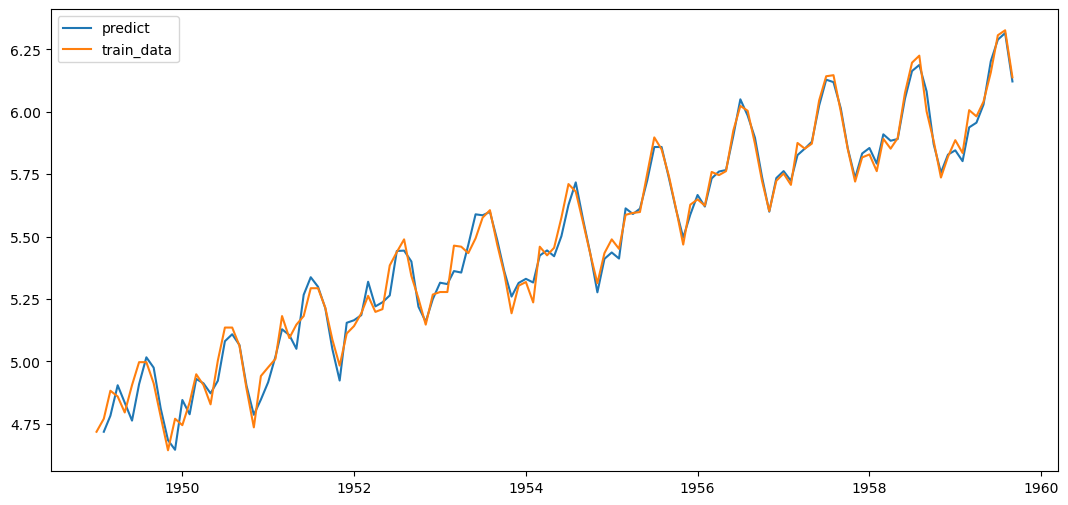

In [114]:
# ARIMA 모델 훈련 결과를 시각화
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()
plt.show()

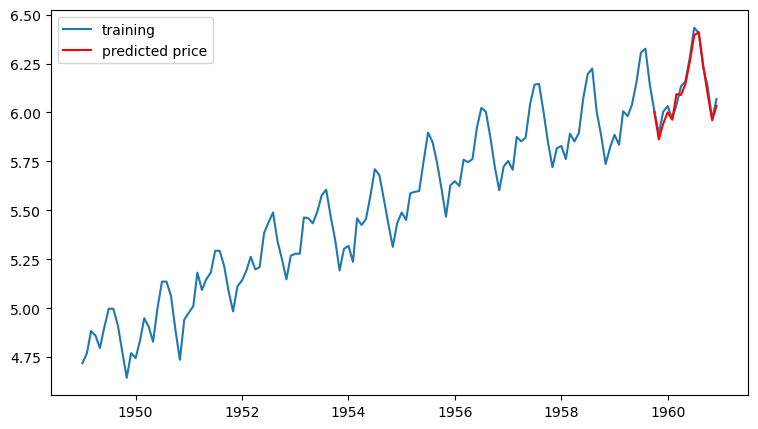

In [125]:
# test data를 활용하여 예측
model = ARIMA(train_data, order=(13, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf(alpha)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(ts_log, label='training')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [126]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  205.49948322183135
MAE:  11.734291955115493
RMSE:  14.335253162111625
MAPE: 2.60%
